# Programming Exercise 1: Linear regression with one variable #

Welcome to programming exercise 1! This exercise will take you through every step of how to implement linear regression from scratch using common scientific packages on provided sample data. 

**Instruction:**
- To run code, click on a corresponding cell and press `Shift+Enter` keys simultaneously or Click `Cell -> Run` Cells.

**Objective:**
- To implement Linear regression to predict a real-valued output based on a single feature input value

**You will learn how to:**
- implement Linear regression with one variable
    - objective/cost function
    - gradient descent algorithm
    - Hypothesis testing
    - visualizing the objective function

## 1 - Import scientific Python libraries ##

First lets run the cell below to import all the packages that you will need for this exercise.
- [NumPy](http://www.numpy.org) is the fundamental package for scientific computing with Python
- [Pandas](https://pandas.pydata.org/) is an open source, easy-to-use data structures and data analysis tools for the Python programming language.
- [Matplotlib](http://matplotlib.org) is a common library to plot graphs in python.
- [os](https://docs.python.org/3/library/os.html#) is a Python module that provides a portable way of using operating system dependent functionality.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import pandas as pd
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot cool figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# IPython extension to manage reloading modules before executing user code.
%load_ext autoreload
%autoreload 2 # Reload all modules (except those excluded by %aimport) every time before executing the Python code typed

## 2 - Overview of the problem ##

**Problem statement**: Suppose you are the CEO of a restaurant franchise and are considering different cities for opening a new outlet. The chain already has trucks in various cities and you have data for profits and populations from the cities. You would like to use this data to help you select which city to expand to next. The file `'./data/ex1data1.txt'` contains the dataset for our linear regression problem. The first column is the population of a city and the second column is the profit of a food truck in that city. A negative value for profit indicates a loss.

Therefore, you will implement linear regression with one variable to predict profits for a food truck.

## 3 - Warmup exercise ###
As a way to warm up, lets define a simple `warmUpExercise()` function that returns a `5 x 5 identity matrix` using numpy library.

In [2]:
#WARMUP EXERCISE TO RETURN AN IDENTITY MATRIX
def warmUpExercise(x):
    id_matrix = np.identity(x)
    print(str(x) +' x '+ str(x) + ' Identity/Diagonal Matrix is:\n')
    return id_matrix

In [3]:
#RUNNING THE WARMUP EXERCISE
print('Running WarmUp Exercise ...\n')
print(warmUpExercise(5))

Running WarmUp Exercise ...

5 x 5 Identity/Diagonal Matrix is:

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


## 3 - Loading dataset and visualizing the training data
Before starting on any task, it is often useful to understand the data by visualizing it. For this dataset, you can use a scatter plot to visualize the data, since it has only two properties to plot (profit and population). (Many
other problems that you will encounter in real life are multi-dimensional and can't be plotted on a 2-d plot.)

The code in the cell below loads the data using the pandas's `read_csv()` function. The dataset is loaded from the data file into the variables X and y:

In [4]:
#IMPORTING AND LOADING SAMPLE DATA FILES
path = os.getcwd() + '\data\ex1data1.txt' #PATH TO THE DATASET
df = pd.read_csv(path, header=None, names=['Population', 'Profit'])
data=df.values
X = data[:,0].reshape(-1,1); # The input variable X
y = data[:,1].reshape(-1,1); # The output variable y
numInstances = len(y); # number of training examples

After loading the training data, we define a function `plotData()` below in order to plot the training data. It is helpful to get insight of the data distribution by plotting in 2D.

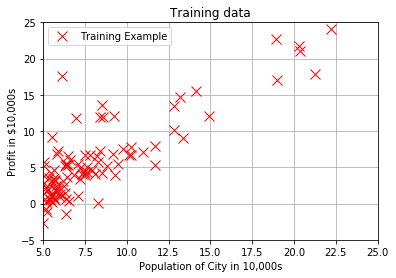

In [5]:
# plotData() function to visualize the distribution of training data
def plotData(x,y):
    plt.plot(x,y,'rx',markersize=10, label='Training Example')
    plt.grid(True) #Always plot.grid
    plt.ylabel('Profit in $10,000s')
    plt.xlabel('Population of City in 10,000s')
    plt.title('Training data')
    plt.axis([5, 25, -5, 25])
    plt.legend()

plotData(X,y) #calling the plotData() function

## 4 - Initial parameter settings##

You will be required to make initial settings for the gradient algorithm. For this exercise, we need to:
   - create a column vector of ones and insert it to X so it becomes the zeroth index of X.
   - randomly initialise `theta` of shape (# of features x 1) with small values to break the symmetry.
   - define the number of iterations our gradient descent algorithm will run.
   - define the value of the ${\alpha}$ for the gradient descent stepsizes.
   
All the above mentioned settings have been set in the cell below.

In [6]:
#SETTINGS FOR RUNNING THE GRADIENT DESCENT ALGORITHM
X = np.insert(X,0,1,axis=1)   # ADD A COLUMN OF ONES TO X (FOR X0 = 1) 
                              # ALTERNATIVELY/ #X_new = np.c_[np.ones((len(X), 1)), X]
(m,n) = X.shape               # Shape of X after adding a column of ones
init_theta = np.random.randn(n,1)  # random initialization theta with small values
iterations = 1500             # Number of iterations
alpha = 0.01                  # Learning rate

## 5 - Gradient descent algorithm
In this part, you will fit the linear regression parameters $\theta$ to our dataset
using gradient descent algorithm. But before we get into the details of implementations, let us review the fundamental theoretical concepts..

**5.1 - Model Representation**:
A supervised learning problem can be described lightly more formally(depicted in the figure below), our goal is, given a training set, to learn a function `h : X → Y` so that h(x) is a “good” predictor for the corresponding value of y. For historical reasons, this function `h` is called a `hypothesis`. Seen pictorially, the process is therefore like this:

![Model Representation](images/model_representation.png)

When the target variable that we’re trying to predict is continuous, such as in our housing example, we call the learning problem a regression problem. When y can take on only a small number of discrete values (such as if, given the living area, we wanted to predict if a dwelling is a house or an apartment, say), we call it a classification problem.

The hypothesis function $h_\theta(x)$ for `linear model` is:
$$ h_\theta(x) = \theta^{T}x = \theta_0 + \theta_1 x_1\tag{1}$$

In [7]:
def hypothesisFunction(x, theta):
    return np.dot(x,theta)

**5.2 - Objective/cost function**: Often refered to as the `Squared error function` or `Mean squared error`, the `objective function` measures the accuracy of the given hypothesis function. Therefore, the aim of linear regression is to minimize the cost function ${J(\theta)}$:

$$ {J(\theta)} = \frac{1}{2m} \sum_{i=1}^m (\hat{y}^{(i)}-y^{(i)})^2 \tag{2}$$

**NOTE**: The mean is halved $\frac{1}{\ 2m}$ as a convenience for the computation of the gradient descent, as the derivation term of the squared function will cancel out the $\frac{1} {\ 2}$ term 

In [8]:
#COST FUNCTION TO COMPUTE THE MEAN SQUARED ERROR
def costFunction(x, y, theta):
    m = len(y); # number of training examples
    y_hat = hypothesisFunction(x, theta);
    errors      = np.subtract(y_hat,y);
    sqErrors    = np.square(errors);
    return (1/(2*m)) * np.sum(sqErrors)

`Run` the cell below to evaluate the defined `costFunction()` above with an initial `theta [0. 0.]`:

In [9]:
#COMPUTING INITIAL COST WITH THETA ZEROS
print('\nTesting the cost function ...\n')
#compute and display initial cost
J = costFunction(X, y, init_theta);
print('With initial theta' + str(init_theta[:,0]) +', Cost computed is %.2f'% J);


Testing the cost function ...

With initial theta[ 0.49671415 -0.1382643 ], Cost computed is 38.55


**5.3 - Gradient descent algorithm**:
Remember that the parameters of the model are the $\theta_j$ values. These are the values that are adjusted to minimize cost $J(\theta)$. One way to do this is to use the batch `gradient descent algorithm`. In batch gradient descent, each iteration performs the update:


    repeat until convergence:
$$\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)} \tag{3}$$ 
        (simultaneously update $\theta_j$ for all j)


where $x_0^{(i)}$ = **1**, **m** is the size of the training set.

Ideally, what we want is that at each step of gradient descent, the parameters $\theta_j$ come closer to the
optimal values that will achieve the lowest cost ${J(\theta)}$.



Now, In this exercise, we have two parameters $\theta_0$ (for bias ${x_0}$) and $\theta_1$ (for ${x_1}$) from the dataset. Its the value of these that give a lowest value of ${J(\theta_0, \theta_1)}$ the gradient descent algorithm seeks to find. **Note**: In this exercise and context ${J(\theta)}$ implies ${J(\theta_0, \theta_1)}$.

The **gradient descent algorithm** will repeat until convergence {
$$\theta_0 = \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_0^{(i)} \tag{4}$$
$$\theta_1 = \theta_1 - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_1^{(i)} \tag{5}$$
} where $x_0^{(i)}$ = **1**,  **m** is the size of the training set.

The `gradientDescentAlgo()` implements the batch gradient descent algorithm described above. The implementation below returns:
 - `theta`: theta values of the computed minimum [$\theta_0$, $\theta_1$]. **Note:** `Theta` is a row vector of shape (1x2)!
 - `cost_vec`: vector of costs  ${J(\theta_0, \theta_1)}$ values computed at each iteration.
 - `bgd_path`: a list of theta values computed at each iteration.

In [10]:
#THE GRADIENT DESCENT OPTIMIZATION METHOD
def gradientDescentAlgo(x, y, theta, alpha, num_iters):
    # Initialize some useful values
    m = len(y); # number of training examples
    cost_vec = [] #Used to plot cost as function of iteration
    bgd_path = [theta] #Used to plot cost as function of iteration
    for iter in range(num_iters):
        cost_vec.append(costFunction(x, y, theta))
        y_hat = hypothesisFunction(x, theta);
        errors = np.subtract(y_hat,y);
        gradient = (alpha/m)*np.dot(x.T,errors);
        theta = theta - gradient;
        bgd_path.append(theta)
    return theta, np.array(cost_vec), np.array(bgd_path)

`Run` the cell below to evaluate the `gradientDescentAlgo()` function. 

In [11]:
#RUNNING GRADIENT DESCENT ALGORITHM
print('\nRunning Gradient Descent ...\n')
theta,cost_vec,gd_path = gradientDescentAlgo(X, y, init_theta, alpha, iterations);
#Print theta to screen
print('Theta found by gradient descent: ', theta[:,0]);
print("\nThis implies with an initial theta of %s after running gradient descent algorithm, \
the resultant optimal values of theta elements are theta_0 = %.8s and theta_1 = %.8s" % \
      (str(init_theta[:,0]),theta[0,0],theta[1,0]))


Running Gradient Descent ...

Theta found by gradient descent:  [-3.59653337  1.16297099]

This implies with an initial theta of [ 0.49671415 -0.1382643 ] after running gradient descent algorithm, the resultant optimal values of theta elements are theta_0 = -3.59653 and theta_1 = 1.162970


**5.4 - Hypothesis testing**: Upon computing the optimal theta values after gradient descent algorithm,  we need to define a `predictFunction()` that takes the form of the hypothesis in section 5.1 in order to make profit predictions.

In [12]:
def predictFunction(x, theta):
    return  np.dot(x,theta)

In [13]:
test_x1 = 3.5; # Population of City A is 35000
test_x2 = 7.0; # Population of City B is 70000
test_px1 = [1, test_x1] # we add a bias 1 to the training example
test_px2 = [1, test_x2] # we add a bias 1 to the training example

In [14]:
profit_1 = predictFunction(test_px1, theta); # profit for city A
profit_2 = predictFunction(test_px2, theta); # profit for city B
print('\nHypothesis: ' + 'h(x) = %0.2f + %0.2fx'%(theta[0],theta[1]) + ' ...')
print('\n...\n')
print('For population = 35,000, the model predicts a profit of $%0.2f' % (profit_1*10000));
print('For population = 70,000, the model predicts a profit of $%0.2f' % (profit_2*10000));
print('\n')


Hypothesis: h(x) = -3.60 + 1.16x ...

...

For population = 35,000, the model predicts a profit of $4738.65
For population = 70,000, the model predicts a profit of $45442.64




## 6 - Debugging 

**6.1 - Plot cost (J) vs number of Iterations**: Recall that the `gradientDescentAlgo()` function returned the vector of cost values at each iteration. Now we need to plot `# of iterations` against `cost_vec` to see if the cost was `reducing` after each iteration!

Therefore, we define a function `plotCost()` that plots the `# of iters` vs `cost` ${J(\theta_0, \theta_1)}$.

In [15]:
#PLOTTING COST(J) VS NUMBER OF ITERATIONS
def plotCost(cost_vec):
    #plt.figure(figsize=(10,8)) #IF YOU WANT TO RESIZE THE FIGURE SIZE REMOVE THE HASHTAG CHARACTER
    plt.plot(range(len(cost_vec)),cost_vec,'b-o', label= r'${J{(\theta)}}$')
    plt.grid(True)
    plt.title("Convergence of Cost Function")
    plt.xlabel('# of Iterations')
    plt.ylabel(r'${J{(\theta)}}$', rotation=1)
    plt.xlim([0,iterations])
    plt.ylim([4,7])
    plt.legend()

**6.2 - Training data with linear regression fit**: Since we have the the hypothesis. Now, we can fit it on the training data to see if it fits well. Therefore, we define a function `plotLinRegressionFit()` that fits the `hypothesis` on the training data.

In [16]:
# DEFINING A FUNCTION FOR PLOTTING A LINEAR REGRESSION FIT ON TRAINING DATA
def plotLinRegressionFit(x,y,h): # h is predicted values
    plt.plot(x,y,'rx',markersize=10)
    plt.plot(x,h,'b-',label = 'Hypothesis: h(x) = %0.2f + %0.2fx'%(theta[0],theta[1]))
    plt.grid(True)
    plt.ylabel('Profit in $10,000s')
    plt.xlabel('Population of City in 10,000s')
    titlestr = 'Hypothesis Function: Y = %.2f + %.2fX' % (theta[0], theta[1])
    plt.title(titlestr)
    plt.axis([5, 25, -5, 25])
    #plt.legend()

**6.3 - Batch gradient descent path:** It would be of value to plot the path taken by gradient descent algorithm by taking count of theta values per iteration. The function below `bgd_path()` plots theta path!

In [17]:
def bgd_path(init_theta, theta, bgd_path):
    plt.plot(bgd_path[:, 0], bgd_path[:, 1], "m-s", linewidth=3, label="Batch")
    plt.plot(theta[0,0],theta[1,0], marker='o', 
             markersize=10,
             color='b', 
             label='End point')         # End point (minimum)
    plt.plot(init_theta[0,0],init_theta[1,0], marker='o', 
             markersize=10,
             color='r', 
             label='Start point ') # Start point of theta
    plt.text(theta[0] + 0.1, theta[1]-.15, "$\mathit{End}$", fontsize=14, color='k')
    plt.text(init_theta[0] - 1.0, init_theta[1]+0.05, "$\mathit{Start}$", fontsize=14, color='k')
    plt.title('Batch gradient descent path plot')
    plt.legend(loc="lower left")
    plt.xlabel(r"$\theta_0$", fontsize=17)
    plt.ylabel(r"$\theta_1$", fontsize=17, rotation=0)
    plt.axis([-4.0, 1.0, -0.2, 1.2])
    plt.grid(True)

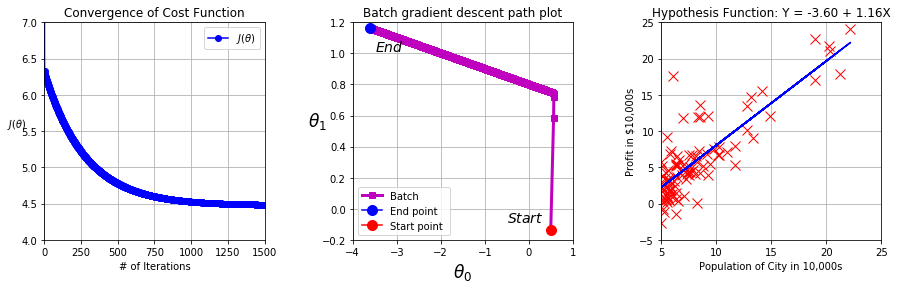

In [18]:
plt.figure(figsize=(15,4))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.subplot(1, 3, 1)
plotCost(cost_vec) # calling the plotCost() function

plt.subplot(1, 3, 2)
bgd_path(init_theta, theta, gd_path) # plot the gradient descent algorithm

plt.subplot(1, 3, 3)
h = predictFunction(X, theta)  # Hypothesis function
plotLinRegressionFit(X,y,h) # Function called to plot the Linear Regression Fitting line on the Training data
plt.show()

**Observation(s):**
 - the training error is steadily decreasing by the number of iteration until cost was about 4.5 at approximately iteration # 1000 in the first plot.
 - looking at the middle figure above, with a random initialization of theta in the `lower right-most cell`, `batch gradient descent` found a local minimum in the upper `left-most cell`.
 - the linear regression fits the training data quiet well according to its distribution.

**6.4 - Contour and surface plots of cost ${J_{(\theta_0, \theta_1)}}$**: To understand the cost function ${J(\theta_0, \theta_1)}$ better, you will now to plot the cost over a 2-dimensional grid of $\theta_0$ and $\theta_1$ values. Moreso, including a surface plot. 

In [19]:
def visualizingCost(x,y):
    #SETTINGS FOR PLOTTING
    theta0_vals = np.linspace(-15, 15, 50)
    theta1_vals = np.linspace(-1.0, 3.0, 50)
    # Grid over which we will calculate J
    xvals, yvals = np.meshgrid(theta0_vals, theta1_vals)
    # Initialize J_vals to a matrix of 0's
    J_vals = np.zeros((len(theta0_vals), len(theta1_vals)));
    for i in range(len(theta0_vals)):
        for j in range(len(theta1_vals)):
            t = [[theta0_vals[i]], [theta1_vals[j]]];
            J_vals[[i],[j]] = costFunction(x, y, t);
    J_vals = J_vals.T
    return J_vals, xvals, yvals

In [20]:
def plotContourAndSurface(X,y,cost_vec):
    #Retrieve values for plotting
    J_vals, xvals, yvals = visualizingCost(X,y)
    
    fig = plt.figure(figsize=(12,4))
    # First subplot of contours
    ax = fig.add_subplot(1, 3, 1)
    plt.contourf(xvals, yvals, J_vals, 
                 norm=LogNorm(vmin=J_vals.min(), 
                              vmax=J_vals.max()),
                 levels=np.logspace(-1, 5, 20))
    plt.contour(xvals,yvals, J_vals, np.logspace(-1, 5, 20), cmap=plt.cm.jet)
    plt.plot(gd_path[:, 0], gd_path[:, 1], "m--", linewidth=2, label="BGD")
    plt.plot(theta[0,0],theta[1,0], marker='o', 
             markersize=10,
             color='g', 
             label='End point')         # End point (minimum)
    plt.plot(init_theta[0,0],init_theta[1,0], marker='o', 
             markersize=10,
             color='r', 
             label='Start point ') # Start point of theta
    plt.text(theta[0] + 1.5, theta[1], "Optimal point", fontsize=14, color='white')
    plt.tight_layout()
    plt.title('Contours of cost J (showing the minimum)',loc='center')
    plt.xlabel(r'$\theta_0$', fontsize=17)
    plt.ylabel(r'$\theta_1$', fontsize=17,rotation=0)
    plt.legend()
  
    # Second subplot of the surface
    ax1 = fig.add_subplot(1, 3, 2, projection='3d')
    ax1.plot_surface(xvals, yvals, J_vals, rstride=1, cstride=1, alpha=0.6, cmap=plt.cm.jet)
    ax1.plot(gd_path[:1500, 0], gd_path[:1500, 1],cost_vec,"m-o", linewidth=2, label="BGD")
    ax1.set_zlabel(r'${J{(\theta)}}$', fontsize=17, rotation=1)
    ax1.set_zlim(J_vals.min(),J_vals.max())
    ax1.set_xlabel(r'$\theta_0$', fontsize=17)
    ax1.set_ylabel(r'$\theta_1$', fontsize=17)
    ax1.view_init(elev=0, azim=360)
    ax1.set_title("Surface of cost J", loc='center')
  
    # Third subplot of the surface with a plot of BGD 
    ax2 = fig.add_subplot(1, 3, 3, projection='3d')
    ax2.plot_surface(xvals, yvals, J_vals, rstride=1, cstride=1, alpha=0.6, cmap=plt.cm.jet)
    ax2.plot(gd_path[:1500, 0], gd_path[:1500, 1],cost_vec,"m-o", linewidth=2, label="BGD")
    ax2.set_zlabel(r'${J{(\theta)}}$', fontsize=17, rotation=1)
    ax2.set_zlim(cost_vec.min(),cost_vec.max())
    ax2.view_init(elev=None, azim=360)
    ax2.set_title("Surface of cost J", loc='center')
    # Naming axes
    for ax in fig.axes:
        ax.set_xlabel(r'$\theta_0$', fontsize=17)
        ax.set_ylabel(r'$\theta_1$', fontsize=17)

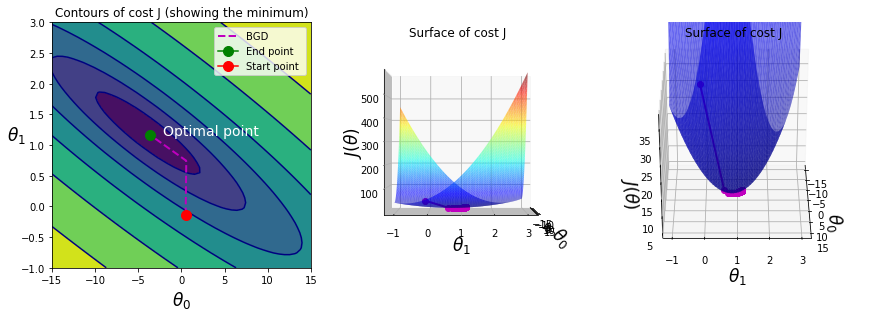

In [21]:
# Contour and surface plots
plotContourAndSurface(X,y,cost_vec)

The graphs above depict how ${J{(\theta)}}$ varies with changes in $\theta_0$ and $\theta_1$. The cost function ${J{(\theta)}}$ is bowl-shaped and has a global mininum as in the **2nd figure** and **3rd figure**. (This is easier to see in the contour plot than in the 3D surface plot). This minimum is the optimal point for $\theta_0$ and $\theta_1$, and each step of gradient descent moves closer to this point as shown in the 2D in the **1st figure above** where we can see gradient descent move from the `red` spot to the `green` optimal point.

<font color='blue'>
**SUCCESSFULLY COMPLETED... WELL DONE!!**

We have successfuly implemented Linear regression with one variable ( or univariate linear regression). Now you can apply it to any regression problem that involves one variable.